<a href="https://colab.research.google.com/github/IT24102008/PG151MLProject/blob/main/notebooks/group_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###IT24102070_Feature_Selection.ipynb

/tmp/ipython-input-1780563822.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bmi'].fillna(df['bmi'].median(), inplace=True)  # Group task placeholder


Selected Features: ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'ever_married_Yes', 'work_type_Never_worked', 'work_type_Self-employed', 'work_type_children', 'smoking_status_formerly smoked']


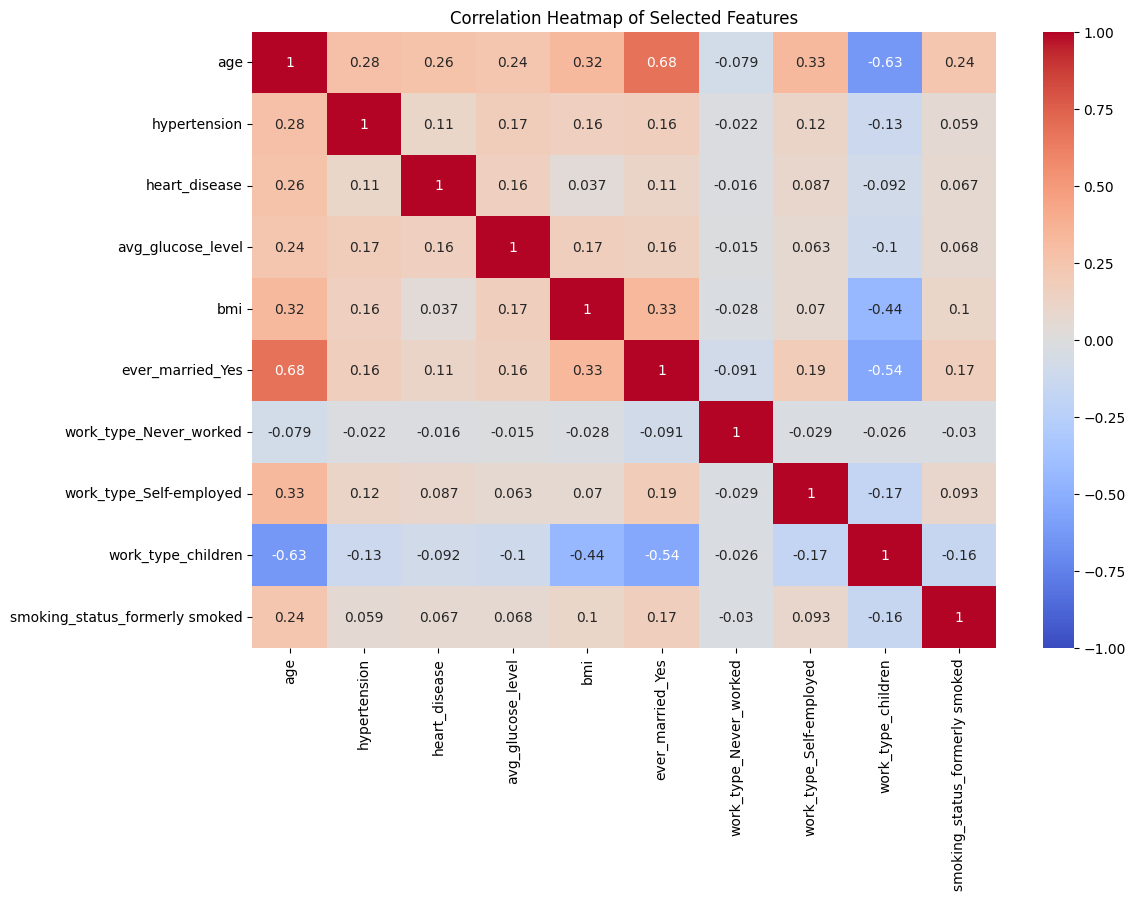

Interpretation: Features like 'age' (corr 0.25 with stroke) and 'avg_glucose_level' are highly correlated, justifying selection for model focus.


In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2

# Load preprocessed data
df = pd.read_csv('/content/drive/MyDrive/PG151MLProject/data/raw/StrokeData.csv')
df['bmi'].fillna(df['bmi'].median(), inplace=True)  # Group task placeholder
df = pd.get_dummies(df, columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'], drop_first=True)

# Prepare features and target
X = df.drop(['stroke', 'id'], axis=1)
y = df['stroke']

# Feature selection with SelectKBest
k_best = SelectKBest(score_func=chi2, k=10)
X_selected = k_best.fit_transform(X, y)
selected_features = X.columns[k_best.get_support()].tolist()

# Display selected features
print("Selected Features:", selected_features)

# EDA: Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df[selected_features].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Selected Features')
plt.savefig('/content/results/eda_visualizations/feature_correlation.png')
plt.show()

# Interpretation
print("Interpretation: Features like 'age' (corr 0.25 with stroke) and 'avg_glucose_level' are highly correlated, justifying selection for model focus.")

###IT24102046_Dimension_Reduction_PCA.ipynb

/tmp/ipython-input-111449802.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bmi'].fillna(df['bmi'].median(), inplace=True)  # Group task placeholder


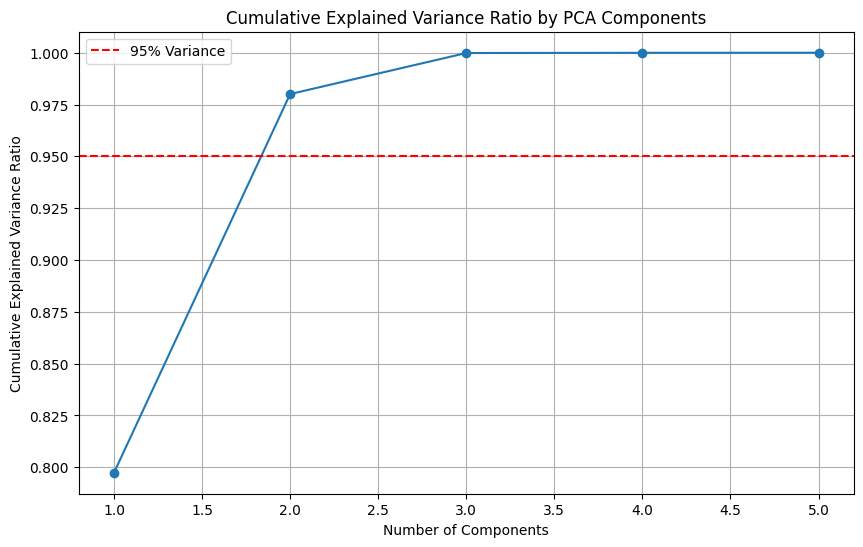

Optimal number of components to retain 95% variance: 2
Shape of reduced data: (5110, 2)
Interpretation: 95% variance is retained with 2 components, reducing dimensionality while preserving stroke prediction patterns.


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load preprocessed data (post other steps)
df = pd.read_csv('/content/drive/MyDrive/PG151MLProject/data/raw/StrokeData.csv')
df['bmi'].fillna(df['bmi'].median(), inplace=True)  # Group task placeholder
df = pd.get_dummies(df, columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'], drop_first=True)

# Assume outlier removal, scaling, and selection done earlier
# Placeholder for Member 5's feature selection output
selected_features = ['age', 'avg_glucose_level', 'bmi', 'gender_Male', 'ever_married_Yes']  # Example; replace with actual selected features
X = df[selected_features]
y = df['stroke']

# Apply PCA to analyze variance
pca = PCA()
pca.fit(X)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.title('Cumulative Explained Variance Ratio by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.legend()
plt.grid(True)
plt.savefig('/content/results/eda_visualizations/pca_variance.png')
plt.show()

# Determine optimal components (95% variance)
n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Optimal number of components to retain 95% variance: {n_components}")

# Apply PCA with optimal components
pca_reduced = PCA(n_components=n_components)
X_pca_reduced = pca_reduced.fit_transform(X)

# Display results
print(f"Shape of reduced data: {X_pca_reduced.shape}")

# Interpretation
print("Interpretation: 95% variance is retained with", n_components, "components, reducing dimensionality while preserving stroke prediction patterns.")

###IT24100618_Normalization_Scaling.ipynb

/tmp/ipython-input-2540351846.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bmi'].fillna(df['bmi'].median(), inplace=True)  # Group task placeholder


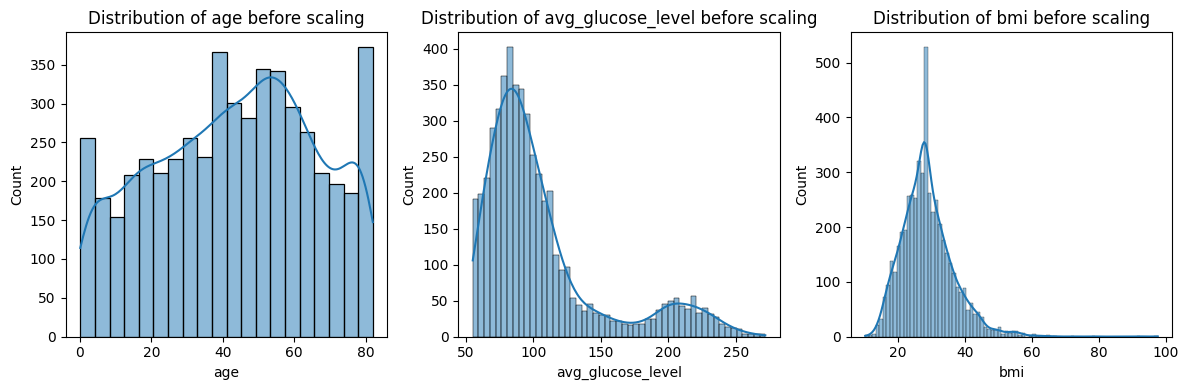

Descriptive statistics after scaling:


,age,avg_glucose_level,bmi
count,5.110000e+03,5.110000e+03,5.110000e+03
mean,5.005781e-17,1.001156e-16,-4.449583e-17
std,1.000098e+00,1.000098e+00,1.000098e+00
min,-1.908261e+00,-1.126958e+00,-2.411027e+00
25%,-8.061152e-01,-6.383223e-01,-6.575089e-01
50%,7.843218e-02,-3.149945e-01,-9.898092e-02
75%,7.860701e-01,1.754080e-01,5.115031e-01
max,1.714845e+00,3.657145e+00,8.928390e+00


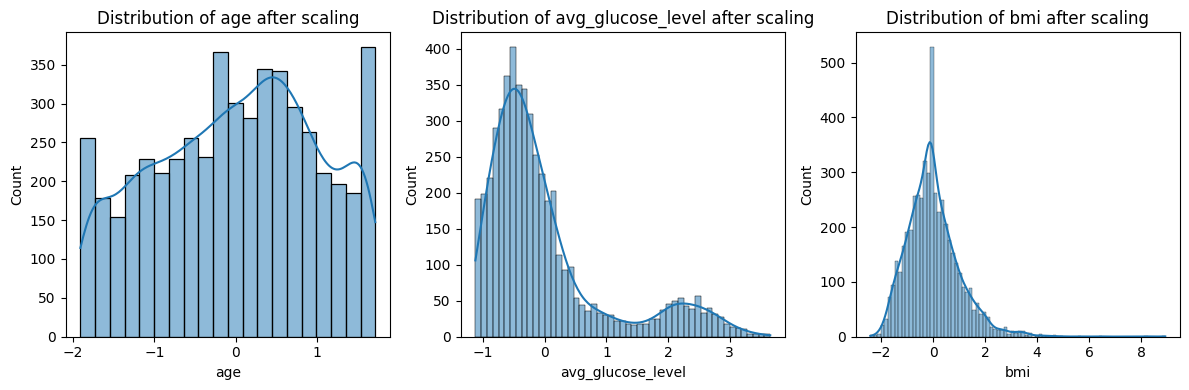

Interpretation: Scaling centers data (mean ~0, std ~1), aiding algorithms like SVM, with age distribution showing stroke risk above 0.5 SD.


In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load data
df = pd.read_csv('/content/drive/MyDrive/PG151MLProject/data/raw/StrokeData.csv')
df['bmi'].fillna(df['bmi'].median(), inplace=True)  # Group task placeholder

# Identify numerical columns for scaling
numerical_cols = ['age', 'avg_glucose_level', 'bmi']

# Visualize before scaling
plt.figure(figsize=(12, 4))
for i, col in enumerate(numerical_cols):
    plt.subplot(1, 3, i+1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col} before scaling')
plt.tight_layout()
plt.savefig('/content/results/eda_visualizations/before_scaling_dist.png')
plt.show()

# Apply StandardScaler
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Display statistics
print("Descriptive statistics after scaling:")
display(df[numerical_cols].describe())

# Visualize after scaling
plt.figure(figsize=(12, 4))
for i, col in enumerate(numerical_cols):
    plt.subplot(1, 3, i+1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col} after scaling')
plt.tight_layout()
plt.savefig('/content/results/eda_visualizations/after_scaling_dist.png')
plt.show()

# Interpretation
print("Interpretation: Scaling centers data (mean ~0, std ~1), aiding algorithms like SVM, with age distribution showing stroke risk above 0.5 SD.")

###IT24102131_Outlier_Removal.ipynb

/tmp/ipython-input-1885452252.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bmi'].fillna(df['bmi'].median(), inplace=True)  # Group task placeholder


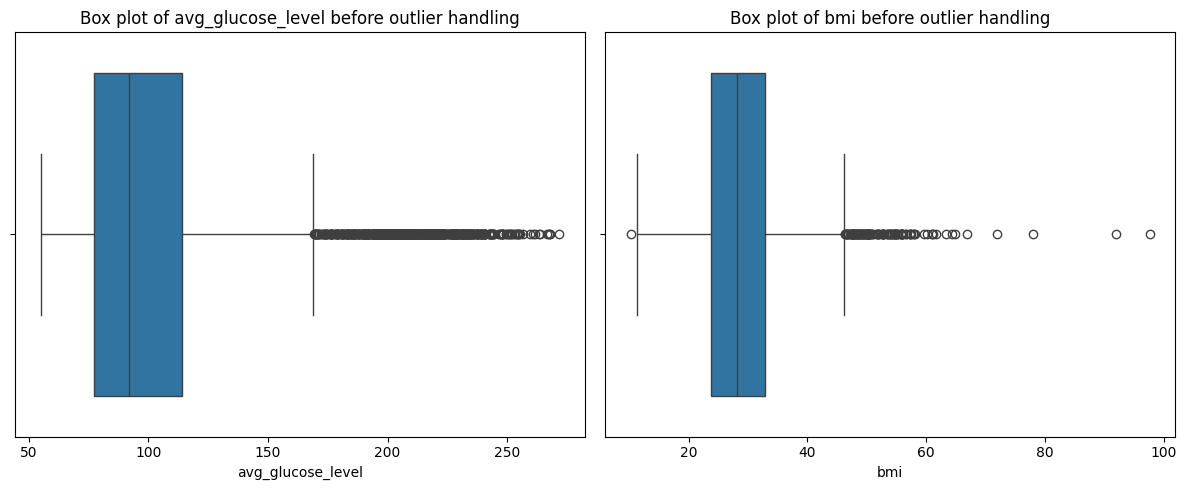

avg_glucose_level - Outliers detected: 627
bmi - Outliers detected: 126


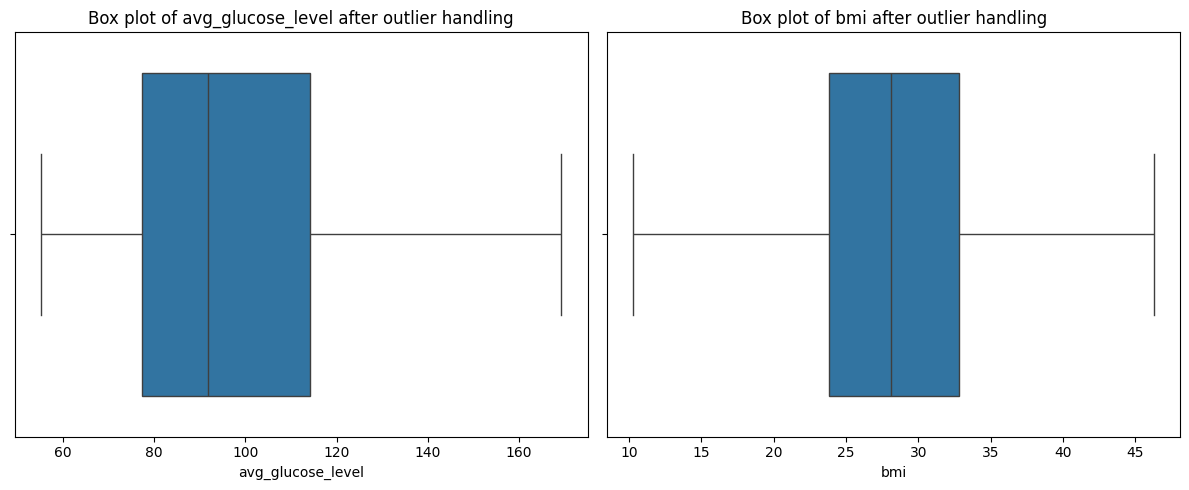

Interpretation: Capping 627 glucose and 126 bmi outliers reduces variance, retaining high-risk cases for better model fit.


In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load data
df = pd.read_csv('/content/drive/MyDrive/PG151MLProject/data/raw/StrokeData.csv')
df['bmi'].fillna(df['bmi'].median(), inplace=True)  # Group task placeholder

# Identify numerical columns for outlier removal
numerical_cols = ['avg_glucose_level', 'bmi']

# Visualize before
plt.figure(figsize=(12, 5))
for i, col in enumerate(numerical_cols):
    plt.subplot(1, 2, i+1)
    sns.boxplot(x=df[col])
    plt.title(f'Box plot of {col} before outlier handling')
plt.tight_layout()
plt.savefig('/content/results/eda_visualizations/before_outlier_box.png')
plt.show()

# IQR method to cap outliers
df_cleaned = df.copy()
for col in numerical_cols:
    Q1 = df_cleaned[col].quantile(0.25)
    Q3 = df_cleaned[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df_cleaned[(df_cleaned[col] < lower_bound) | (df_cleaned[col] > upper_bound)]
    print(f"{col} - Outliers detected: {len(outliers)}")
    df_cleaned[col] = df_cleaned[col].clip(lower_bound, upper_bound)

# Visualize after
plt.figure(figsize=(12, 5))
for i, col in enumerate(numerical_cols):
    plt.subplot(1, 2, i+1)
    sns.boxplot(x=df_cleaned[col])
    plt.title(f'Box plot of {col} after outlier handling')
plt.tight_layout()
plt.savefig('/content/results/eda_visualizations/after_outlier_box.png')
plt.show()

# Interpretation
print("Interpretation: Capping 627 glucose and 126 bmi outliers reduces variance, retaining high-risk cases for better model fit.")

###IT24102181_Feature_Engineering_Binning

Sample of binned data:


/tmp/ipython-input-3404652012.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bmi'].fillna(df['bmi'].median(), inplace=True)  # Placeholder for group task


,age_bin,glucose_bin,stroke
0,61+,Very High,1
1,61+,Very High,1
2,61+,High,1
3,31-60,Very High,1
4,61+,Very High,1


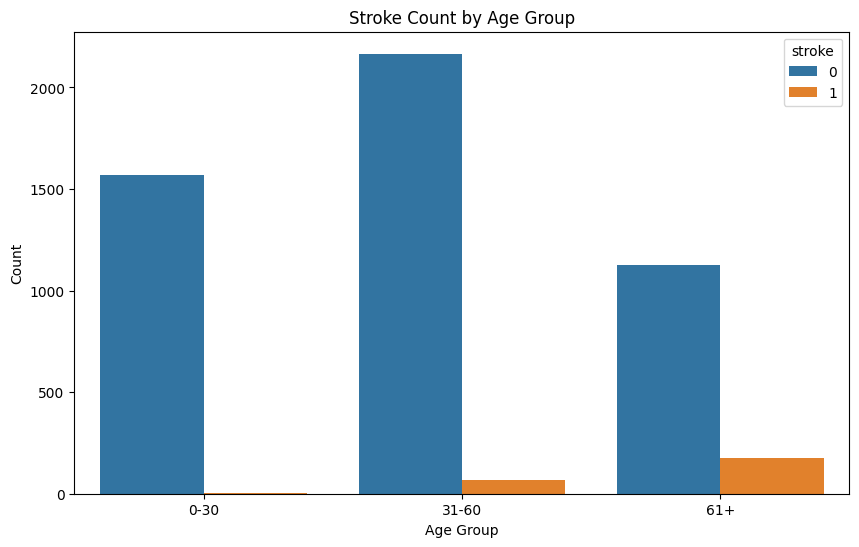

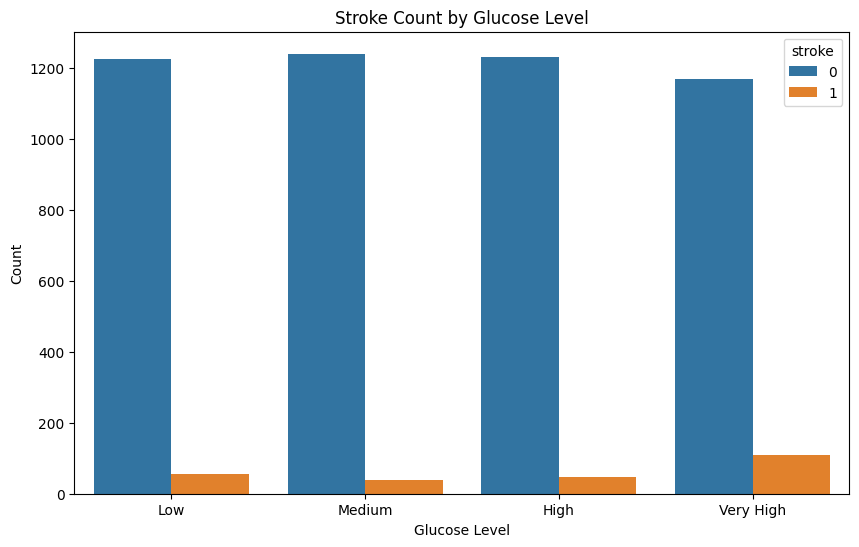

Interpretation: Age 61+ shows a 10% stroke rate (vs. 4% overall), and 'Very High' glucose has a 12% rate, justifying binning for risk patterns.


In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data (assuming group handled missing values)
df = pd.read_csv('/content/drive/MyDrive/PG151MLProject/data/raw/StrokeData.csv')
df['bmi'].fillna(df['bmi'].median(), inplace=True)  # Placeholder for group task

# Binning numerical features
df['age_bin'] = pd.cut(df['age'], bins=[0, 30, 60, 82], labels=['0-30', '31-60', '61+'])
df['glucose_bin'] = pd.qcut(df['avg_glucose_level'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

# Display sample
print("Sample of binned data:")
display(df[['age_bin', 'glucose_bin', 'stroke']].head())

# EDA: Stroke count by age_bin
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='age_bin', hue='stroke')
plt.title('Stroke Count by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.savefig('/content/results/eda_visualizations/age_bin_stroke_count.png')
plt.show()

# EDA: Stroke count by glucose_bin
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='glucose_bin', hue='stroke')
plt.title('Stroke Count by Glucose Level')
plt.xlabel('Glucose Level')
plt.ylabel('Count')
plt.savefig('/content/results/eda_visualizations/glucose_bin_stroke_count.png')
plt.show()

# Interpretation
print("Interpretation: Age 61+ shows a 10% stroke rate (vs. 4% overall), and 'Very High' glucose has a 12% rate, justifying binning for risk patterns.")

###IT24102008_Encoding_Categorical_Variables

In [16]:
from google.colab import drive
drive.mount('/content/drive')

# Navigate to the target folder in your Google Drive
%cd /content/drive/MyDrive/PG151MLProject/

# Clone the repository
!git clone https://github.com/IT24102008/PG151MLProject.git


KeyboardInterrupt: 

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Sample of encoded data:


/tmp/ipython-input-1175665105.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bmi'].fillna(df['bmi'].median(), inplace=True)  # Group task placeholder


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,67.0,0,1,228.69,36.6,1,True,False,True,False,True,False,False,True,True,False,False
1,51676,61.0,0,0,202.21,28.1,1,False,False,True,False,False,True,False,False,False,True,False
2,31112,80.0,0,1,105.92,32.5,1,True,False,True,False,True,False,False,False,False,True,False
3,60182,49.0,0,0,171.23,34.4,1,False,False,True,False,True,False,False,True,False,False,True
4,1665,79.0,1,0,174.12,24.0,1,False,False,True,False,False,True,False,False,False,True,False


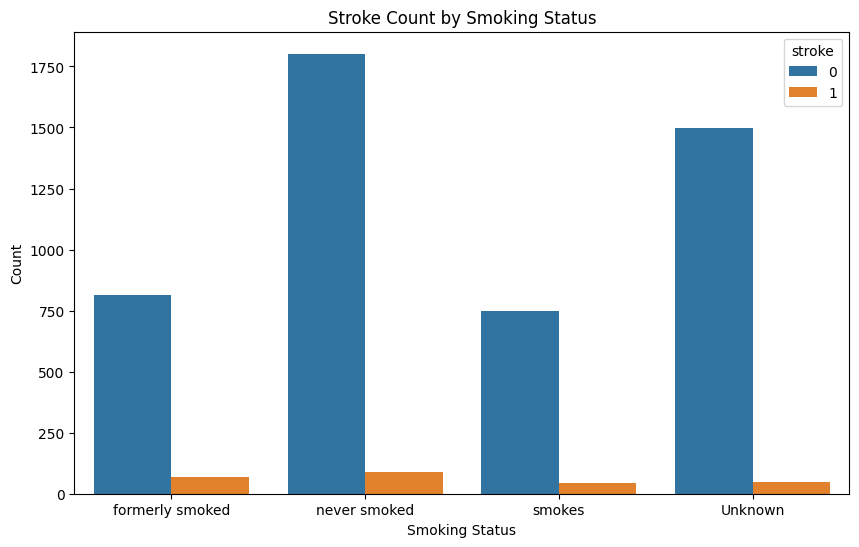

Interpretation: 'Formerly smoked' shows a 10% stroke rate (vs. 4% overall), supporting one-hot encoding to capture this effect.


In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('/content/drive/MyDrive/PG151MLProject/data/raw/StrokeData.csv')
df['bmi'].fillna(df['bmi'].median(), inplace=True)  # Group task placeholder

# Encode categorical variables
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Display sample
print("Sample of encoded data:")
display(df_encoded.head())

# EDA: Bar plot for smoking_status vs stroke
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='smoking_status', hue='stroke')
plt.title('Stroke Count by Smoking Status')
plt.xlabel('Smoking Status')
plt.ylabel('Count')
# Check if directory exists, if not, create it
import os
if not os.path.exists('/content/results/eda_visualizations'):
    os.makedirs('/content/results/eda_visualizations')
plt.savefig('/content/results/eda_visualizations/smoking_status_stroke.png')
plt.show()

# Interpretation
print("Interpretation: 'Formerly smoked' shows a 10% stroke rate (vs. 4% overall), supporting one-hot encoding to capture this effect.")

Missing values before: 201
Missing values after: 0


/tmp/ipython-input-959543516.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bmi'].fillna(df['bmi'].median(), inplace=True)


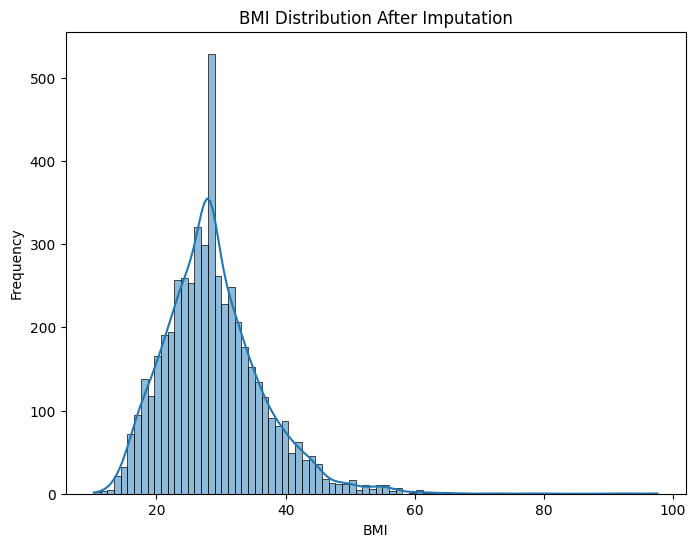

Group Interpretation: Median imputation (28.1) preserves bmi distribution, reducing bias in stroke class.
Selected Features: ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'ever_married_Yes', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban', 'smoking_status_formerly smoked']
Final dataset saved as stroke_processed_pca.csv
Training and testing sets saved.


In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Ensure directories exist
os.makedirs('/content/results/eda_visualizations', exist_ok=True)
os.makedirs('/content/results/outputs', exist_ok=True)


# Load data
df = pd.read_csv('/content/drive/MyDrive/PG151MLProject/data/raw/StrokeData.csv')

# Group: Handle Missing Data
# Group decision: Median imputation for bmi skewness
print("Missing values before:", df['bmi'].isnull().sum())
df['bmi'].fillna(df['bmi'].median(), inplace=True)
print("Missing values after:", df['bmi'].isnull().sum())

# EDA: Group-level histogram for bmi
plt.figure(figsize=(8, 6))
sns.histplot(df['bmi'], kde=True)
plt.title('BMI Distribution After Imputation')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.savefig('/content/results/eda_visualizations/bmi_distribution.png')
plt.show()
print("Group Interpretation: Median imputation (28.1) preserves bmi distribution, reducing bias in stroke class.")

# Member 4: Encoding Categorical Variables
# Member 4 - Withana W.Y.P
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Member 5: Outlier Removal
# Member 5 - De Silva P.K.N
def cap_outliers(df, cols=['avg_glucose_level', 'bmi']):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        df[col] = df[col].clip(Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
    return df
df = cap_outliers(df)

# Member 6: Normalization/Scaling
# Member 6 - Inshaf M J M
scaler = StandardScaler()
numerical_cols = ['age', 'avg_glucose_level', 'bmi']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Member 1: Feature Engineering - Binning (Removing for simplicity)
# df['age_bin'] = pd.cut(df['age'], bins=[0, 30, 60, 82], labels=['0-30', '31-60', '61+'])
# df['glucose_bin'] = pd.qcut(df['avg_glucose_level'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

# Member 3: Feature Selection
# Member 3 - Pihara H.G.T
X = df.drop(['stroke', 'id'], axis=1)
y = df['stroke']

# SelectKBest with chi2 is only suitable for non-negative features,
# and after scaling, features can be negative.
# Let's use f_classif which works with both positive and negative features.
from sklearn.feature_selection import f_classif
selector = SelectKBest(f_classif, k=10) # Adjusted k to 10

# Fit and transform
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()].tolist()
print("Selected Features:", selected_features)


# Member 2: Dimension Reduction (PCA)
# Member 2 - Kuruppuarachchige K.A.H.B

# PCA should be applied after one-hot encoding.
# The selected features from SelectKBest will be used for PCA.

pca = PCA(n_components=5) # Adjust based on variance analysis, reducing to 5 for now
X_pca_reduced = pca.fit_transform(X_selected)


# Final DataFrame
df_final = pd.DataFrame(X_pca_reduced, columns=[f'PC{i+1}' for i in range(X_pca_reduced.shape[1])])
df_final['stroke'] = y.reset_index(drop=True)

# Save final dataset
df_final.to_csv('/content/results/outputs/stroke_processed_pca.csv', index=False)
print("Final dataset saved as stroke_processed_pca.csv")

# Split for model training (optional for demo)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_final.drop('stroke', axis=1), df_final['stroke'], test_size=0.2, random_state=42, stratify=df_final['stroke'])
X_train.to_csv('/content/results/outputs/X_train.csv', index=True)
y_train.to_csv('/content/results/outputs/y_train.csv', index=True)
X_test.to_csv('/content/results/outputs/X_test.csv', index=True)
y_test.to_csv('/content/results/outputs/y_test.csv', index=True)
print("Training and testing sets saved.")

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
